<a href="https://colab.research.google.com/github/DivyaMeenaSundaram/Deep_Learning_Lab/blob/main/Stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# =============================
# STEP 1: SETUP ENVIRONMENT
# =============================
!pip install tensorflow numpy pandas scikit-learn --quiet

import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Bidirectional, LSTM, Dense, BatchNormalization, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os

# =============================
# STEP 2: LOAD THE DATA
# =============================
# Option 1: Mount Drive (recommended if file is in Drive)
from google.colab import drive
drive.mount('/content/drive')

# Replace path below with your mHealth CSV or folder path
file_path = '/content/mhealth_raw_data.csv'

# Option 2: Upload manually if stored locally on your computer
# from google.colab import files
# uploaded = files.upload()
# file_path = list(uploaded.keys())[0]

# Load dataset, skipping the header row
df = pd.read_csv(file_path, header=0, sep=',')

# =============================
# STEP 3: DATA PREPROCESSING
# =============================
# mHealth has 23 sensor signals + activity label at the last column (usually column 24)
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values

# Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Segment the continuous data into windows (e.g., 128 timesteps)
def create_segments(data, labels, window_size=128, step=64):
    X, y = [], []
    for i in range(0, len(data) - window_size, step):
        X.append(data[i:i+window_size])
        y.append(labels[i+window_size-1])
    return np.array(X), np.array(y)

X, y = create_segments(features, labels, window_size=128, step=64)

# Encode labels
num_classes = len(np.unique(y))
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_cat = to_categorical(y_encoded, num_classes=num_classes)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# =============================
# STEP 4: BUILD NUMERICAL HAR ENCODER
# =============================
input_shape = X_train.shape[1:]  # (128, 23)

inputs = Input(shape=input_shape)
x = Conv1D(128, kernel_size=5, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(256, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Bidirectional(LSTM(128, return_sequences=False))(x)
x = Dense(256, activation='relu')(x)
embedding = Dense(128, activation='linear', name='embedding')(x)

# Optional classification output
output = Dense(num_classes, activation='softmax', name='classifier')(embedding)

model = Model(inputs, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# =============================
# STEP 5: TRAIN THE MODEL
# =============================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=1
)

# =============================
# STEP 6: EXTRACT EMBEDDINGS
# =============================
# Create a separate encoder model
encoder = Model(inputs, embedding)
embeddings = encoder.predict(X_test)
print("Embeddings shape:", embeddings.shape)

# =============================
# STEP 7: SAVE EMBEDDINGS
# =============================
np.save('mHealth_embeddings.npy', embeddings)
print("Embeddings saved as mHealth_embeddings.npy")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X_train shape: (1788, 128, 13)
y_train shape: (1788, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 13)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 128, 128)       │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601,601 (2.29 MB)

 Trainable params: 600,833 (2.29 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 332ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 380ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 391ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 382ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 397ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 376ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step 

In [3]:
output = Dense(num_classes, activation='softmax')(embedding)
clf_model = Model(inputs, output)
clf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       447

    accuracy                           1.00       447
   macro avg       1.00      1.00      1.00       447
weighted avg       1.00      1.00      1.00       447



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


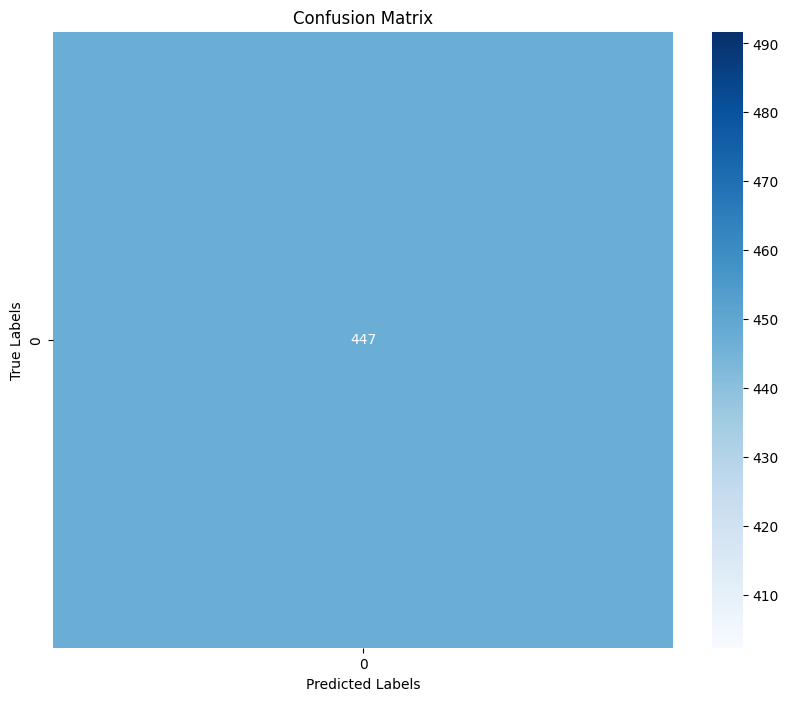

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =============================
# EVALUATE ON TEST SET
# =============================
# Predict probabilities
y_pred_prob = clf_model.predict(X_test)

# Convert one-hot vectors to label indices
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# Basic Accuracy
test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# =============================
# CLASSIFICATION REPORT
# =============================
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[str(lbl) for lbl in np.unique(y_true)]))

# =============================
# CONFUSION MATRIX
# =============================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [5]:
print("Unique labels in training:", np.unique(np.argmax(y_train, axis=1)))
print("Unique labels in test:", np.unique(np.argmax(y_test, axis=1)))


Unique labels in training: [0]
Unique labels in test: [0]


In [6]:
import pandas as pd

file_path = '/content/mhealth_raw_data.csv'
df = pd.read_csv(file_path, header=0, sep=',', engine='python')

print("Shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nColumn names:\n", df.columns)


Shape: (1215745, 14)

First 5 rows:
       alx     aly      alz       glx      gly      glz     arx     ary  \
0  2.1849 -9.6967  0.63077  0.103900 -0.84053 -0.68762 -8.6499 -4.5781   
1  2.3876 -9.5080  0.68389  0.085343 -0.83865 -0.68369 -8.6275 -4.3198   
2  2.4086 -9.5674  0.68113  0.085343 -0.83865 -0.68369 -8.5055 -4.2772   
3  2.1814 -9.4301  0.55031  0.085343 -0.83865 -0.68369 -8.6279 -4.3163   
4  2.4173 -9.3889  0.71098  0.085343 -0.83865 -0.68369 -8.7008 -4.1459   

        arz      grx     gry       grz  Activity   subject  
0  0.187760 -0.44902 -1.0103  0.034483         0  subject1  
1  0.023595 -0.44902 -1.0103  0.034483         0  subject1  
2  0.275720 -0.44902 -1.0103  0.034483         0  subject1  
3  0.367520 -0.45686 -1.0082  0.025862         0  subject1  
4  0.407290 -0.45686 -1.0082  0.025862         0  subject1  

Column names:
 Index(['alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'arx', 'ary', 'arz', 'grx',
       'gry', 'grz', 'Activity', 'subject'],
      dtype='o

In [7]:
print("Unique activities:", df['Activity'].unique())
print(df['Activity'].value_counts())


Unique activities: [ 0  1  2  3  4  6  7  8  9 10 11 12  5]
Activity
0     872550
1      30720
2      30720
3      30720
4      30720
9      30720
5      30720
11     30720
10     30720
7      29441
8      29337
6      28315
12     10342
Name: count, dtype: int64


Shape: (1215745, 14)
Columns: ['alx', 'aly', 'alz', 'glx', 'gly', 'glz', 'arx', 'ary', 'arz', 'grx', 'gry', 'grz', 'Activity', 'subject']
Unique activities: [ 0  1  2  3  4  6  7  8  9 10 11 12  5]
Activity
0     872550
1      30720
2      30720
3      30720
4      30720
9      30720
5      30720
11     30720
10     30720
7      29441
8      29337
6      28315
12     10342
Name: count, dtype: int64
Segmented X shape: (18995, 128, 12)
Segmented y shape: (18995,)

Class Weights:
{0: np.float64(0.10711289992880756), 1: np.float64(3.0440705128205128), 2: np.float64(3.0440705128205128), 3: np.float64(3.0440705128205128), 4: np.float64(3.0440705128205128), 5: np.float64(3.0440705128205128), 6: np.float64(3.3113968184789715), 7: np.float64(3.2025289778714434), 8: np.float64(3.2025289778714434), 9: np.float64(3.0440705128205128), 10: np.float64(3.0440705128205128), 11: np.float64(3.0440705128205128), 12: np.float64(9.132211538461538)}


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 12)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 128, 64)        │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 128, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,909 (1.50 MB)

 Trainable params: 392,525 (1.50 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.3934 - loss: 0.8643 - val_accuracy: 0.7081 - val_loss: 0.7313 - learning_rate: 0.0010
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.7945 - loss: 0.1102 - val_accuracy: 0.7989 - val_loss: 0.6986 - learning_rate: 0.0010
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.7516 - loss: 0.1656 - val_accuracy: 0.8331 - val_loss: 0.6214 - learning_rate: 0.0010
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8285 - loss: 0.0923 - val_accuracy: 0.8544 - val_loss: 0.5534 - learning_rate: 0.0010
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.8549 - loss: 0.0814 - val_accuracy: 0.8444 - val_loss: 0.6605 - learning_rate: 0.0010
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8544 - loss: 0.0791 - val_accuracy: 0.8547 - val_loss: 0.6127 - learning_rate: 0.0010
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.8714 - loss: 0.

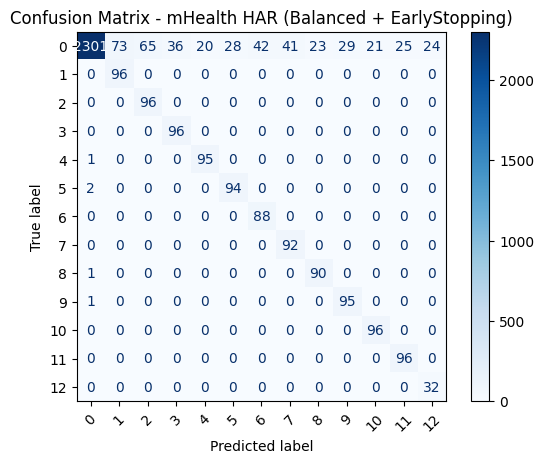

119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step
Embeddings shape: (3799, 128)
Embeddings saved as mHealth_embeddings_balanced.npy


In [9]:
# =====================================
# STEP 1: SETUP
# =====================================
!pip install tensorflow numpy pandas scikit-learn matplotlib imbalanced-learn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Bidirectional, LSTM, Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# =====================================
# STEP 2: LOAD DATA
# =====================================
file_path = '/content/mhealth_raw_data.csv'
df = pd.read_csv(file_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Unique activities:", df['Activity'].unique())
print(df['Activity'].value_counts())

# =====================================
# STEP 3: PREPROCESSING
# =====================================
# Extract features and labels
features = df.iloc[:, :-2].values   # All columns except Activity & subject
labels = df['Activity'].values

# Standardize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Function to create overlapping windows
def create_segments(data, labels, window_size=128, step=64):
    X, y = [], []
    for i in range(0, len(data) - window_size, step):
        X.append(data[i:i+window_size])
        y.append(labels[i+window_size-1])
    return np.array(X), np.array(y)

X, y = create_segments(features, labels, window_size=128, step=64)
print("Segmented X shape:", X.shape)
print("Segmented y shape:", y.shape)

# One-hot encode labels
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes=num_classes)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

# =====================================
# STEP 4: CLASS IMBALANCE HANDLING
# =====================================
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(class_weights))
print("\nClass Weights:")
print(class_weights)

# =====================================
# STEP 5: MODEL - NUMERICAL HAR ENCODER (FIXED)
# =====================================
input_shape = X_train.shape[1:]  # (128, 12)

inputs = Input(shape=input_shape)
x = Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)   # Keep sequences for pooling
x = GlobalAveragePooling1D()(x)                          # Pool across time dimension
x = Dense(256, activation='relu')(x)
embedding = Dense(128, activation='linear', name='embedding')(x)

# Classifier output
output = Dense(num_classes, activation='softmax', name='classifier')(embedding)

model = Model(inputs, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


# =====================================
# STEP 6: CALLBACKS (EarlyStopping + ReduceLROnPlateau)
# =====================================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,           # stop if no improvement after 5 epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,           # reduce LR by half
    patience=3,           # if no improvement for 3 epochs
    min_lr=1e-6,
    verbose=1
)

# =====================================
# STEP 7: TRAIN WITH CLASS WEIGHTS
# =====================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# =====================================
# STEP 8: EVALUATE MODEL
# =====================================
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - mHealth HAR (Balanced + EarlyStopping)")
plt.show()

# =====================================
# STEP 9: EMBEDDING EXTRACTION
# =====================================
encoder = Model(inputs, embedding)
embeddings = encoder.predict(X_test)
print("Embeddings shape:", embeddings.shape)
np.save('mHealth_embeddings_balanced.npy', embeddings)
print("Embeddings saved as mHealth_embeddings_balanced.npy")


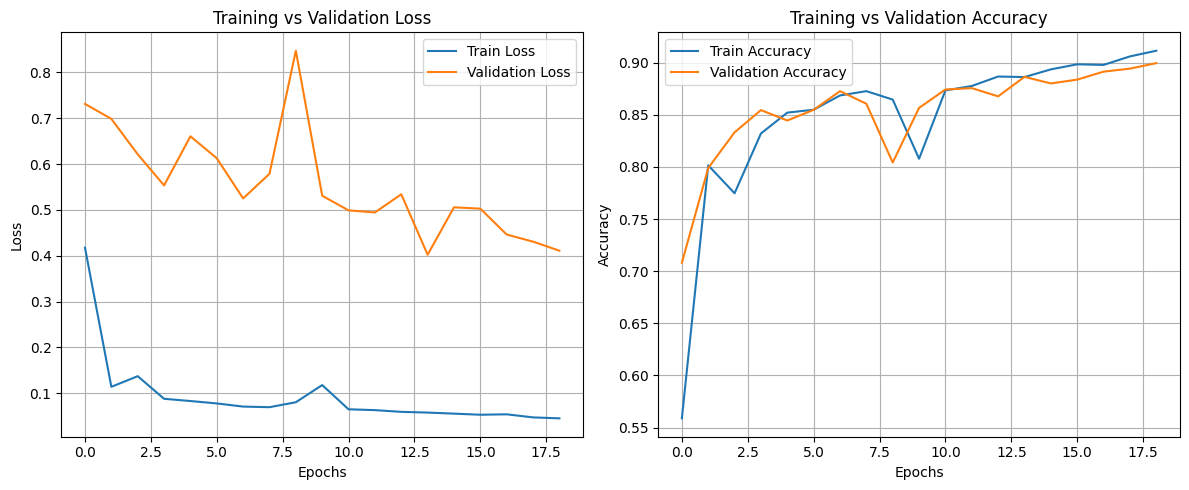

In [10]:
# =====================================
# STEP 10: PLOT TRAINING HISTORY
# =====================================
plt.figure(figsize=(12,5))

# Plot Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
